# Data Mining Project

## Part 2 - Classification and accuracy assessment

### Import required libraries

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.base import clone
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

### Import the datasets

In [5]:
data_1 = pd.read_csv('data/data_subset_1.csv')
data_2 = pd.read_csv('data/data_subset_2.csv')
datasets = [data_1, data_2]

### How to deal with class imbalance

We'll try three ways to take into account class imbalance :
1) We won't change the data but use balanced_accuracy instead of accuracy
2) We will oversample the minority class
3) We will undersample the majority class

### Loading different classifiers

In [7]:
clfs = [GaussianNB(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), KNeighborsClassifier(), RandomForestClassifier(random_state=71223)]

### Repeated Stratified KFold

We will use Repeated Stratified KFold for cross validation, with 2 folds and 5 repeats

In [8]:
rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=71223)

### Keep the scores

We will have 2 dataset, with 3 methods to tackle imbalanced data, 10 repeats*folds and 5 classifiers

In [9]:
# DATASETS, SAMPLING, CLFS, FOLDS*REPEATS
scores = np.zeros((len(datasets),3,len(clfs),10))

### Testing the different methods

In [20]:
for idx_data, data in enumerate(datasets):
    for idx_sample in range(3):
        # We keep the current data
        if idx_sample == 0:
            X, y = data.iloc[:,:-1], data.iloc[:, -1]

        # We oversample
        elif idx_sample == 1:
            data_oversample = data.copy()
            max_size = data_oversample['y'].value_counts().max()
            lst = [data_oversample]
            for class_index, group in data_oversample.groupby('y'):
                lst.append(group.sample(max_size-len(group), replace=True))
            frame_new = pd.concat(lst)
            X, y = frame_new.iloc[:,:-1], frame_new.iloc[:, -1]
        
        # We undersample
        else:
            pos_class = data_1[data_1['y']==1]
            neg_class = data_1[data_1['y']==0]
            neg_class = neg_class.sample(n=len(pos_class), random_state=71223)
            frame_new = pd.concat([pos_class,neg_class],axis=0)
            X, y = frame_new.iloc[:,:-1], frame_new.iloc[:, -1]

        for idx_rskf, (train_index, test_index) in enumerate(rskf.split(X, y)):
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_test, y_test = X.iloc[test_index], y.iloc[test_index]
            
            for idx_clf, clf in enumerate(clfs):
                clf = clone(clf)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                score = balanced_accuracy_score(y_test, y_pred)
                scores[idx_data, idx_sample, idx_clf, idx_rskf] = score
        

### Save the results array

In [23]:
np.save("results_scores", scores)

### Visualizing the means for each characteristics

In [60]:
clfs = ["GaussianNB", "LDA", "QDA", "KNN", "RandomForest"]
mean_clf = np.mean(scores, axis=(0,1,3))
std_clf = np.std(scores, axis=(0,1,3))
for idx_clf, clf in enumerate(clfs):
    print(f"Average score for {clf} is {mean_clf[idx_clf]:.3f}")

(5,) (5,)
Average score for GaussianNB is 0.730
Average score for LDA is 0.812
Average score for QDA is 0.616
Average score for KNN is 0.813
Average score for RandomForest is 0.848


<ErrorbarContainer object of 3 artists>

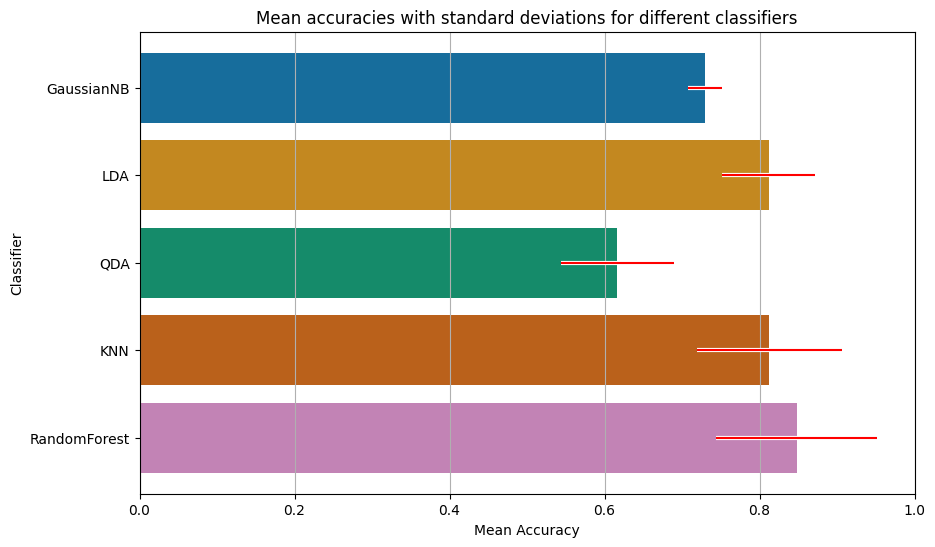

In [80]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette('colorblind', len(mean_clf))
p = sns.barplot(x=mean_clf, y=clfs, orient='h', palette=colors)
plt.title('Mean accuracies with standard deviations for different classifiers')
plt.xlabel('Mean Accuracy')
plt.ylabel('Classifier')
plt.xlim(0, 1.0)  # Adjust limits if needed
plt.grid(axis='x')

p.errorbar(y=range(len(std_clf)), 
           x=mean_clf, 
           xerr=std_clf, 
           fmt='none',
           linewidth=3, c='w')

p.errorbar(y=range(len(std_clf)), 
           x=mean_clf, 
           xerr=std_clf, 
           fmt='none',
           c='r')

Random forest has the best results followed by 5-NN and LDA. GaussianNB is not as good and QDA achieves the worst performances of the group

In [87]:
samplings = ["No sampling", "Oversampling", "Undersampling"]
mean_sampling = np.mean(scores, axis=(0,2,3))
std_sampling = np.std(scores, axis=(0,2,3))
for idx_sampling, sampling in enumerate(samplings):
    print(f"Average score for {sampling} is {mean_sampling[idx_sampling]:.3f}")

Average score for No sampling is 0.683
Average score for Oversampling is 0.807
Average score for Undersampling is 0.801


<ErrorbarContainer object of 3 artists>

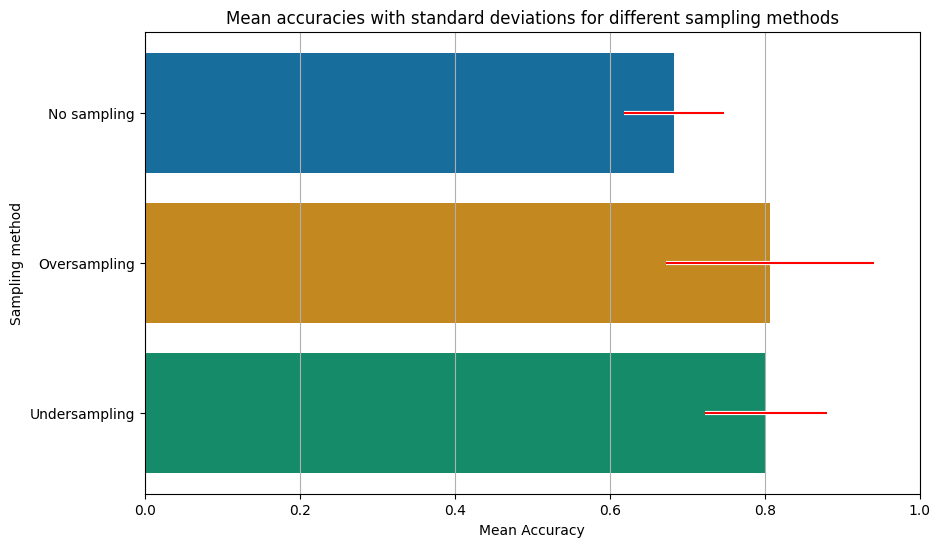

In [88]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette('colorblind', len(mean_sampling))
p = sns.barplot(x=mean_sampling, y=samplings, orient='h', palette=colors)
plt.title('Mean accuracies with standard deviations for different sampling methods')
plt.xlabel('Mean Accuracy')
plt.ylabel('Sampling method')
plt.xlim(0, 1.0)  # Adjust limits if needed
plt.grid(axis='x')

p.errorbar(y=range(len(std_sampling)), 
           x=mean_sampling, 
           xerr=std_sampling, 
           fmt='none',
           linewidth=3, c='w')

p.errorbar(y=range(len(std_sampling)), 
           x=mean_sampling, 
           xerr=std_sampling, 
           fmt='none',
           c='r')

We directly see the effect of not doing anything when there is imbalanced data. Both undersampling and oversamplign achieve good and similar results but the results are way worse when no processing was done

In [90]:
datas = ["Original dataset", "Dataset with correlated columns removed"]
mean_data = np.mean(scores, axis=(1,2,3))
std_data = np.std(scores, axis=(1,2,3))
for idx_data, data in enumerate(datas):
    print(f"Average score for {data} is {mean_data[idx_data]:.3f}")

Average score for Original dataset is 0.766
Average score for Dataset with correlated columns removed is 0.762


<ErrorbarContainer object of 3 artists>

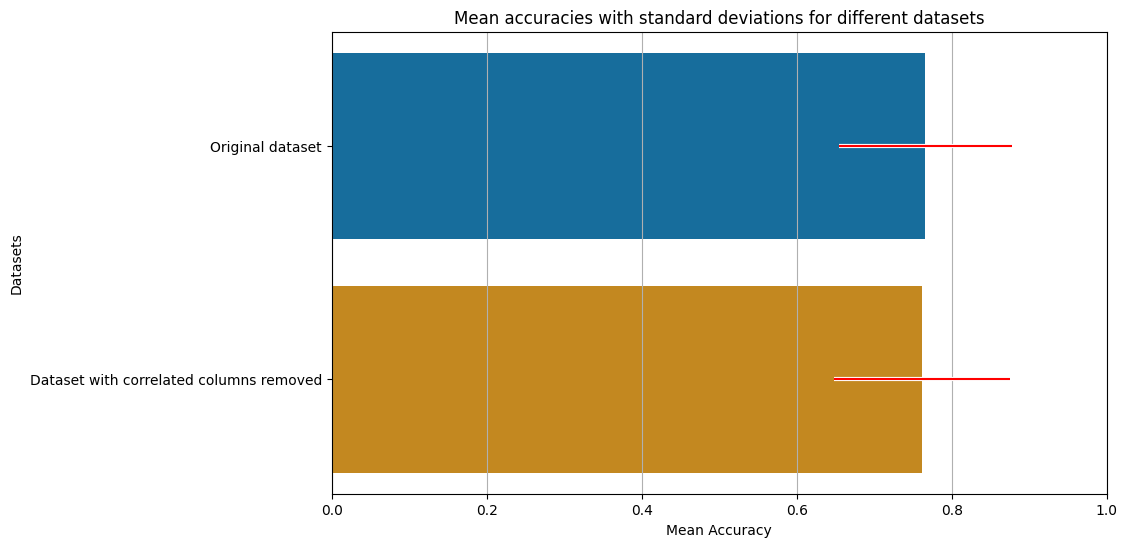

In [92]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette('colorblind', len(mean_sampling))
p = sns.barplot(x=mean_data, y=datas, orient='h', palette=colors)
plt.title('Mean accuracies with standard deviations for different datasets')
plt.xlabel('Mean Accuracy')
plt.ylabel('Datasets')
plt.xlim(0, 1.0)  # Adjust limits if needed
plt.grid(axis='x')

p.errorbar(y=range(len(std_data)), 
           x=mean_data, 
           xerr=std_data, 
           fmt='none',
           linewidth=3, c='w')

p.errorbar(y=range(len(std_data)), 
           x=mean_data, 
           xerr=std_data, 
           fmt='none',
           c='r')

We can see that the results are similar, which means that we didn't lose significant data by removing highly correlated columns. Howerver this can allow to run algorithms faster with less computational power needed. In this case, as the algorithms used were pretty light, it didn't really have an impact but we can understand how removing useless features can be very helpful for bigger datasets or algorithms that requires more computational power (like neural networks)